In [20]:
import nibabel as nib
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model, regularizers
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from time import time

In [21]:
def calculate_label(image, threshold=0.01):
    """
    Determina o label da subimagem com base no percentual de fundo não-preto.
    :param subimage: Array da subimagem.
    :param threshold: Percentual mínimo de fundo não-preto para considerar como label 1.
    :return: String indicando o label.
    """
    # Total de pixels na subimagem
    total_pixels = image.size
    # Número de pixels não-preto
    non_zero_pixels = np.count_nonzero(image)
    # Proporção de pixels não-preto
    non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
    
    # Verifica se há lesão e se o fundo não-preto é maior que o limiar
    if np.any(image == 1) and non_black_ratio >= threshold:
        return 1
    else:
        return 0

def load_patient_data(folder, patient_id):
    """
    Carrega os dados de um único paciente (imagens, máscaras e labels) de um diretório.

    Args:
        folder (str): Caminho da pasta contendo os dados dos pacientes.
        patient_id (str): ID do paciente a ser carregado.

    Returns:
        dict: Dados do paciente, incluindo imagens, máscaras e labels para os lados esquerdo e direito.
              Retorna None se o paciente não for encontrado.
    """
    patient_path = os.path.join(folder, patient_id)
    if not os.path.exists(patient_path):
        print(f"Paciente {patient_id} não encontrado na pasta {folder}.")
        return None

    # Inicializa estruturas para armazenar os dados do paciente
    patient_data = {
        "images_left": [],
        "images_right": [],
        "mask_left": [],
        "mask_right": [],
        "labels_left": [],
        "labels_right": [],
    }

    areas_image = ["left", "right"]
    areas_mask = ["lesion_left", "lesion_right"]
    path_left = os.path.join(patient_path, areas_image[0])
    path_right = os.path.join(patient_path, areas_image[1])
    lesion_path_left = os.path.join(patient_path, areas_mask[0])
    lesion_path_right = os.path.join(patient_path, areas_mask[1])

    # Verifica se os diretórios existem
    if not os.path.exists(path_left) or not os.path.exists(path_right) or \
       not os.path.exists(lesion_path_left) or not os.path.exists(lesion_path_right):
        print(f"Estrutura de diretórios inválida para o paciente {patient_id}.")
        return None

    # Carrega as imagens e máscaras do lado esquerdo e direito
    for patch_id_left, mask_id_left, patch_id_right, mask_id_right in zip(
        os.listdir(path_left), os.listdir(lesion_path_left),
        os.listdir(path_right), os.listdir(lesion_path_right)
    ):
        img_path_left = os.path.join(path_left, patch_id_left)
        mask_path_left = os.path.join(lesion_path_left, mask_id_left)
        img_path_right = os.path.join(path_right, patch_id_right)
        mask_path_right = os.path.join(lesion_path_right, mask_id_right)

        for img_left, msk_left, img_right, msk_right in zip(
            os.listdir(img_path_left), os.listdir(mask_path_left),
            os.listdir(img_path_right), os.listdir(mask_path_right)
        ):
            # Carrega os dados do lado esquerdo
            data_left = nib.load(os.path.join(img_path_left, img_left)).get_fdata()
            data_msk_left = nib.load(os.path.join(mask_path_left, msk_left)).get_fdata()
            if len(data_left) > 0 or len(data_msk_left) > 0:
                patient_data["images_left"].append(data_left)
                patient_data["mask_left"].append(data_msk_left)
                patient_data["labels_left"].append(calculate_label(data_msk_left))

            # Carrega os dados do lado direito
            data_right = nib.load(os.path.join(img_path_right, img_right)).get_fdata()
            data_msk_right = nib.load(os.path.join(mask_path_right, msk_right)).get_fdata()
            if len(data_right) > 0 or len(data_msk_right) > 0:
                patient_data["images_right"].append(data_right)
                patient_data["mask_right"].append(data_msk_right)
                patient_data["labels_right"].append(calculate_label(data_msk_right))

    # Gera os pares de labels
    labels_pair = []
    for label_left, label_right in zip(patient_data["labels_left"], patient_data["labels_right"]):
        if label_left == 0 and label_right == 0:
            labels_pair.append(0)
        else:
            labels_pair.append(1)
    patient_data["labels_pair"] = labels_pair

    print(f"Paciente {patient_id} carregado com sucesso.")
    print(f"Total de recortes: {len(labels_pair)}")
    return patient_data, labels_pair

In [22]:
# Função para carregar as coordenadas dos arquivos txt
def load_one_coordinate(coordinates_path):
    with open(coordinates_path, 'r') as f:
        coords = [tuple(map(int, line.strip().split(','))) for line in f.readlines()]
                
    return coords

# Função para normalizar entre 0 e 1
def normalize_minmax(image_data): 
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized_data = (image_data - min_val) / (max_val - min_val)
    return normalized_data

# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images_original, all_images_opposite, all_labels):
    selected_images_original = {}
    selected_images_opposite = {}
    selected_labels = []
    
    for patient in patients:
        selected_images_original[patient] = []
        selected_images_opposite[patient] = []
        if patient in all_images_original and patient in all_images_opposite:
            selected_images_original[patient].extend(all_images_original[patient])
            selected_images_opposite[patient].extend(all_images_opposite[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return selected_images_original, selected_images_opposite, selected_labels

In [117]:
# Função para preparar os dados para treino e validação
def prepare_data_for_training_balanced(images_left, images_right, labels_pair, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_original = {}
    balanced_images_opposite = {}
    balanced_labels = {}
    balanced_mask_original = {}
    balanced_mask_opposite = {}
    balanced_coords = {}
    
    for patient_id in images_left:
        class_1_labels = []
        class_0_labels = []
        class_1_left = {}
        class_0_left = {}
        class_1_right = {}
        class_0_right = {}
        class_1_mask_left = {}
        class_0_mask_left = {}
        class_1_mask_right = {}
        class_0_mask_right = {}
        class_1_coordinates = {}
        class_0_coordinates = {}
        class_1_left[patient_id] = []
        class_0_left[patient_id] = []
        class_1_right[patient_id] = []
        class_0_right[patient_id] = []
        class_1_mask_left[patient_id] = []
        class_0_mask_left[patient_id] = []
        class_1_mask_right[patient_id] = []
        class_0_mask_right[patient_id] = []
        class_1_coordinates[patient_id] = []
        class_0_coordinates[patient_id] = []
        index = 0
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels\n",
        if len(labels_pair[patient_id]) == 0:
            continue
        
        for label in labels_pair[patient_id]:
            image_left = (images_left[patient_id])[index]
            image_right = (images_right[patient_id])[index]
            mask_image_left = (mask_left[patient_id])[index]
            mask_image_right = (mask_right[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels.append(label)
                class_1_left[patient_id].append(image_left)
                class_1_right[patient_id].append(image_right)
                class_1_mask_left[patient_id].append(mask_image_left)
                class_1_mask_right[patient_id].append(mask_image_right)
            else:
                class_0_labels.append(label)
                class_0_left[patient_id].append(image_left)
                class_0_right[patient_id].append(image_right)
                class_0_mask_left[patient_id].append(mask_image_left)
                class_0_mask_right[patient_id].append(mask_image_right)
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com labels 1: {class_1_count}")

        # Fazer undersampling aleatório da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        class_0_count = len(class_0_labels)
        if class_0_count > class_1_count:
            sampled_indices = np.random.choice(range(class_0_count), class_1_count, replace=False)
            sampled_class_0_slices_left = [class_0_left[patient_id][i] for i in sampled_indices]
            sampled_class_0_slices_right = [class_0_right[patient_id][i] for i in sampled_indices]
            class_0_original_modified = {}
            class_0_original_modified[patient_id] = []
            class_0_opposite_modified = {}
            class_0_opposite_modified[patient_id] = []
            sampled_class_0_mask_left = [class_0_mask_left[patient_id][i] for i in sampled_indices]
            sampled_class_0_mask_right = [class_0_mask_right[patient_id][i] for i in sampled_indices]
            class_0_mask_original_modified = {}
            class_0_mask_original_modified[patient_id] = []
            class_0_mask_opposite_modified = {}
            class_0_mask_opposite_modified[patient_id] = []

            for left_image, left_mask in zip(sampled_class_0_slices_left, sampled_class_0_mask_left):
                class_0_original_modified[patient_id].append(left_image)
                class_0_mask_original_modified[patient_id].append(left_mask)
            for right_image, right_mask in zip(sampled_class_0_slices_right, sampled_class_0_mask_right):
                class_0_opposite_modified[patient_id].append(right_image)
                class_0_mask_opposite_modified[patient_id].append(right_mask)
            class_0_labels = [0] * class_1_count

        balanced_images_original[patient_id] = list(class_1_left[patient_id]) + list(class_0_original_modified[patient_id])
        balanced_images_opposite[patient_id] = list(class_1_right[patient_id]) + list(class_0_opposite_modified[patient_id])
        balanced_labels[patient_id] = class_1_labels + class_0_labels
        balanced_mask_original[patient_id] = list(class_1_mask_left[patient_id]) + list(class_0_mask_original_modified[patient_id])
        balanced_mask_opposite[patient_id] = list(class_1_mask_right[patient_id]) + list(class_0_mask_opposite_modified[patient_id])
    remove_patients = []
    for patient_id, images in balanced_images_original.items():
        if len(images) <= 4:
            remove_patients.append(patient_id)
        else:
            print(f"Paciente {patient_id}: Total de pares de recortes (label 1 + label 0): {len(images)}")
    for i in range(len(remove_patients)):
        balanced_images_original.pop(remove_patients[i])
        balanced_images_opposite.pop(remove_patients[i])
        balanced_labels.pop(remove_patients[i])
        
    # Separar os dados por conjunto (treino, validação, teste)
    patients = list(set(balanced_labels.keys()))
    train_patients, valtest_patients = train_test_split(patients, train_size = train_size)
    valid_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size))
    
    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(valid_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    mask_test_original, mask_test_opposite, _ = select_by_patients(test_patients, balanced_mask_original, balanced_mask_opposite, balanced_labels)
    
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 0: {y_test.count(0)}")
    
    return X_train_original, X_train_opposite, X_val_original, X_val_opposite, np.array(y_train), np.array(y_val), train_patients, valid_patients, test_patients

# Função para preparar os dados para teste
def prepare_data_for_training_unbalanced(images_left, images_right, labels_pair, mask_left, mask_right, train_patients, valid_patients, test_patients, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_original = {}
    balanced_images_opposite = {}
    balanced_labels = {}
    balanced_mask_original = {}
    balanced_mask_opposite = {}
    balanced_coords = {}
    
    for patient_id in images_left:
        if len(labels_pair[patient_id]) == 0:
            continue
        
        grid_path = f"Coordenadas_grid/{patient_id}"  # Caminho dos grids do paciente
        grids_names = os.listdir(grid_path)
        grids_names = [g.split(".")[0] for g in grids_names]
        
        # Lista para armazenar grupos de fatias
        groups = []  
        coords = {}
        coords[patient_id] = []
        cont = 0
        
        slices = []
        for slice in os.listdir(grid_path):
            slices.append(slice)
        
        grid_data_path = f"{grid_path}/{slices[cont]}"
        coords[patient_id].append(load_one_coordinate(grid_data_path))
        
        # Criar os grupos de 4 fatias
        i = 0
        while i < len(labels_pair[patient_id]):
            if i != 0:
                grid_data_path = f"{grid_path}/{slices[cont]}"
                coords[patient_id].append(load_one_coordinate(grid_data_path))
            group = {
                "labels": labels_pair[patient_id][i:i+len(coords[patient_id])],
                "images_left": images_left[patient_id][i:i+len(coords[patient_id])],
                "images_right": images_right[patient_id][i:i+len(coords[patient_id])],
                "mask_left": mask_left[patient_id][i:i+len(coords[patient_id])],
                "mask_right": mask_right[patient_id][i:i+len(coords[patient_id])],
                "coordinates": coords[patient_id][cont]
            }
            groups.append(group)
            cont += 1
            i += len(coords[patient_id])

         # Separar grupos com label 1
        class_1_groups = [group for group in groups if 1 in group["labels"]]        
        
        balanced_images_original[patient_id] = []
        balanced_images_opposite[patient_id] = []
        balanced_labels[patient_id] = []
        balanced_mask_original[patient_id] = []
        balanced_mask_opposite[patient_id] = []
        balanced_coords[patient_id] = []
        for group in class_1_groups:
            balanced_images_original[patient_id].extend(group["images_left"])
            balanced_images_opposite[patient_id].extend(group["images_right"])
            balanced_labels[patient_id].extend(group["labels"])
            balanced_mask_original[patient_id].extend(group["mask_left"])
            balanced_mask_opposite[patient_id].extend(group["mask_right"])
            balanced_coords[patient_id].extend(group["coordinates"])
    for patient_id, images in balanced_images_original.items():
        print(f"Paciente {patient_id}: Total de pares de recortes: {len(images)}")
        
    # Separar os dados por conjunto (treino, validação, teste)
    # patients = list(set(balanced_labels.keys()))
    # train_patients, valtest_patients = train_test_split(patients, train_size = train_size)
    # valid_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size))

    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(valid_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    mask_test_original, mask_test_opposite, _ = select_by_patients(test_patients, balanced_mask_original, balanced_mask_opposite, balanced_labels)

    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 0: {y_test.count(0)}")
    
    return X_train_original, X_train_opposite, X_val_original, X_val_opposite, X_test_original, X_test_opposite, np.array(y_train), np.array(y_val), np.array(y_test), mask_test_original, mask_test_opposite, balanced_images_original, balanced_images_opposite, balanced_mask_original, balanced_mask_opposite, balanced_coords

In [110]:
# Função para construir o modelo CNN 2D
def build_cnn_model():
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2))) 
    model.add(layers.Dropout(0.3)) 
    
    model.add(layers.Conv2D(64, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2))) 
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2))) 
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (3,3), padding="same", kernel_regularizer=regularizers.l2(0.01), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2), padding="same")) 
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())

    return model

In [111]:
# Função para construir a rede siamesa
def build_siamese_model(input_shape):
    input_original = Input(shape=input_shape)
    input_opposite = Input(shape=input_shape)

    # Criar a CNN base compartilhada
    cnn_base = build_cnn_model()
    
    # Aplicar a mesma CNN base para ambas as entradas
    output_original = cnn_base(input_original)
    output_opposite = cnn_base(input_opposite)

    # Calcula a diferença absoluta
    # l1_distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([output_original, output_opposite])

    # Concatenar as duas saídas (Lado esquerdo + Contra-lateral)
    concatenated = layers.Concatenate()([output_original, output_opposite])
    concatenated = layers.BatchNormalization()(concatenated)

    output = layers.Dense(1, activation='sigmoid')(concatenated)
    
    siamese_model = Model(inputs=[input_original, input_opposite], outputs=output)
    siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")])

    return siamese_model

In [26]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [27]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


In [29]:

# Caminho da pasta contendo os dados dos pacientes
folder = "Novo_Contralateral"

# Lista de IDs dos pacientes
patient_ids = os.listdir(folder)

X_left, X_right, y, mask_left, mask_right = {}, {}, {}, {}, {}

# Processa um paciente por vez
for patient_id in patient_ids:
    # Carrega os dados do paciente
    patient_data, labels_pair = load_patient_data(folder, patient_id)
    
    if patient_data is not None:
        X_left[patient_id] = patient_data["images_left"]
        X_right[patient_id] = patient_data["images_right"]
        mask_left[patient_id] = patient_data["mask_left"]
        mask_right[patient_id] = patient_data["mask_right"]
        y[patient_id] = labels_pair
        

Paciente sub-00H10 carregado com sucesso.
Total de recortes: 919
Paciente sub-02A13 carregado com sucesso.
Total de recortes: 961
Paciente sub-03C08 carregado com sucesso.
Total de recortes: 826
Paciente sub-06C09 carregado com sucesso.
Total de recortes: 928
Paciente sub-14F04 carregado com sucesso.
Total de recortes: 959
Paciente sub-16E03 carregado com sucesso.
Total de recortes: 1006
Paciente sub-16G09 carregado com sucesso.
Total de recortes: 946
Paciente sub-16I12 carregado com sucesso.
Total de recortes: 942
Paciente sub-19F09 carregado com sucesso.
Total de recortes: 987
Paciente sub-19G04 carregado com sucesso.
Total de recortes: 929
Paciente sub-22F14 carregado com sucesso.
Total de recortes: 941
Paciente sub-25B08 carregado com sucesso.
Total de recortes: 961
Paciente sub-26B09 carregado com sucesso.
Total de recortes: 943
Paciente sub-29D03 carregado com sucesso.
Total de recortes: 897
Paciente sub-31F07 carregado com sucesso.
Total de recortes: 950
Paciente sub-34J06 carre

In [52]:
# Preparar dados para treino e validação
train_left_balanced, train_right_balanced, valid_left_balanced, valid_right_balanced, y_train_balanced, y_valid_balanced, train_patients, valid_patients, test_patients = prepare_data_for_training_balanced(X_left, X_right, y, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1)

# Adiciono camada de cor
train_left_balanced = normalize_minmax(np.array([elemento for lista in train_left_balanced.values() for elemento in lista]))
train_left_balanced = np.expand_dims(train_left_balanced, axis=-1)
train_right_balanced = normalize_minmax(np.array([elemento for lista in train_right_balanced.values() for elemento in lista]))
train_right_balanced = np.expand_dims(train_right_balanced, axis=-1)
valid_left_balanced = normalize_minmax(np.array([elemento for lista in valid_left_balanced.values() for elemento in lista]))
valid_left_balanced = np.expand_dims(valid_left_balanced, axis=-1)
valid_right_balanced = normalize_minmax(np.array([elemento for lista in valid_right_balanced.values() for elemento in lista]))
valid_right_balanced = np.expand_dims(valid_right_balanced, axis=-1)

Paciente sub-00H10: Total de pares de recortes com labels 1: 58
Paciente sub-02A13: Total de pares de recortes com labels 1: 75
Paciente sub-03C08: Total de pares de recortes com labels 1: 75
Paciente sub-06C09: Total de pares de recortes com labels 1: 27
Paciente sub-14F04: Total de pares de recortes com labels 1: 14
Paciente sub-16E03: Total de pares de recortes com labels 1: 64
Paciente sub-16G09: Total de pares de recortes com labels 1: 97
Paciente sub-16I12: Total de pares de recortes com labels 1: 30
Paciente sub-19F09: Total de pares de recortes com labels 1: 189
Paciente sub-19G04: Total de pares de recortes com labels 1: 23
Paciente sub-22F14: Total de pares de recortes com labels 1: 46
Paciente sub-25B08: Total de pares de recortes com labels 1: 90
Paciente sub-26B09: Total de pares de recortes com labels 1: 122
Paciente sub-29D03: Total de pares de recortes com labels 1: 68
Paciente sub-31F07: Total de pares de recortes com labels 1: 53
Paciente sub-34J06: Total de pares de 

In [101]:
# Construir e compilar o modelo CNN
input_shape = (train_left_balanced[0].shape)

siamese_model = build_siamese_model(input_shape)
siamese_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 40, 42, 1)]          0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 40, 42, 1)]          0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 256)                  653184    ['input_9[0][0]',             
                                                                     'input_10[0][0]']            
                                                                                                  
 concatenate_4 (Concatenate  (None, 512)                  0         ['sequential_4[0][0]',  

In [102]:
# Adicionar o callback EarlyStopping e low rate scheduler
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Salvar a melhor epoca
checkpoint = callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss',  save_best_only=True,  save_weights_only=True, mode='min')

# Ajusta learning rate
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.3, patience=5, verbose=1)

# Treinamento do modelo siames
history = siamese_model.fit([train_left_balanced, train_right_balanced], y_train_balanced, validation_data=([valid_left_balanced, valid_right_balanced], y_valid_balanced), batch_size=64, epochs=150, callbacks=[checkpoint, reduce_lr])

Epoch 1/150
74/74 [==============================] - 15s 140ms/step - loss: 2.5301 - accuracy: 0.5454 - precision: 0.5463 - recall: 0.5359 - val_loss: 1.1660 - val_accuracy: 0.4688 - val_precision: 0.4183 - val_recall: 0.1599 - lr: 0.0100
Epoch 2/150
74/74 [==============================] - 10s 136ms/step - loss: 1.0534 - accuracy: 0.5729 - precision: 0.5722 - recall: 0.5778 - val_loss: 1.0282 - val_accuracy: 0.5305 - val_precision: 0.5245 - val_recall: 0.6541 - lr: 0.0100
Epoch 3/150
74/74 [==============================] - 11s 145ms/step - loss: 5.4394 - accuracy: 0.5435 - precision: 0.5438 - recall: 0.5402 - val_loss: 3.3625 - val_accuracy: 0.4833 - val_precision: 0.4795 - val_recall: 0.3910 - lr: 0.0100
Epoch 4/150
74/74 [==============================] - 10s 133ms/step - loss: 1.8105 - accuracy: 0.5725 - precision: 0.5731 - recall: 0.5680 - val_loss: 1.2850 - val_accuracy: 0.5065 - val_precision: 0.5088 - val_recall: 0.3779 - lr: 0.0100
Epoch 5/150
74/74 [=========================

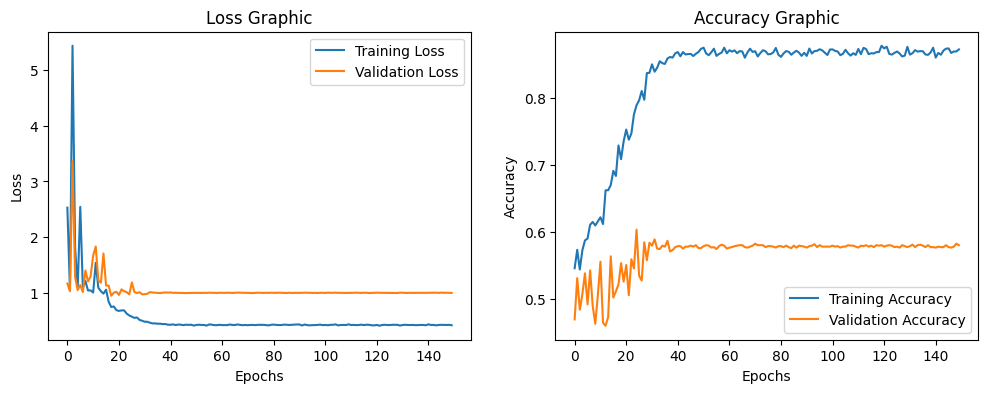

In [103]:
# Plotar o histórico do treinamento
plot_training_history(history)

In [118]:
# Preparar dados para teste e predição
X_train_left, X_train_right, X_valid_left, X_valid_right, X_test_left, X_test_right, y_train, y_valid, y_test, mask_left_test, mask_right_test, images_left_by_patient, images_right_by_patient, mask_left_by_patient, mask_right_by_patient, coordinates_grid = prepare_data_for_training_unbalanced(X_left, X_right, y, mask_left, mask_right, train_patients, valid_patients, test_patients, train_size=0.7, validation_size=0.2, test_size=0.1)

# Crio copias para o print em pdf
train_left = X_train_left
train_right = X_train_right
valid_left = X_valid_left
valid_right = X_valid_right
test_left = X_test_left
test_right = X_test_right

# Adiciono camada de cor
X_train_left = normalize_minmax(np.array([elemento for lista in X_train_left.values() for elemento in lista]))
X_train_left = np.expand_dims(X_train_left, axis=-1)
X_train_right = normalize_minmax(np.array([elemento for lista in X_train_right.values() for elemento in lista]))
X_train_right = np.expand_dims(X_train_right, axis=-1)
X_valid_left = normalize_minmax(np.array([elemento for lista in X_valid_left.values() for elemento in lista]))
X_valid_left = np.expand_dims(X_valid_left, axis=-1)
X_valid_right = normalize_minmax(np.array([elemento for lista in X_valid_right.values() for elemento in lista]))
X_valid_right = np.expand_dims(X_valid_right, axis=-1)
X_test_left = normalize_minmax(np.array([elemento for lista in X_test_left.values() for elemento in lista]))
X_test_left = np.expand_dims(X_test_left, axis=-1)
X_test_right = normalize_minmax(np.array([elemento for lista in X_test_right.values() for elemento in lista]))
X_test_right = np.expand_dims(X_test_right, axis=-1)

Paciente sub-00H10: Total de pares de recortes: 150
Paciente sub-02A13: Total de pares de recortes: 442
Paciente sub-03C08: Total de pares de recortes: 325
Paciente sub-06C09: Total de pares de recortes: 129
Paciente sub-14F04: Total de pares de recortes: 114
Paciente sub-16E03: Total de pares de recortes: 280
Paciente sub-16G09: Total de pares de recortes: 273
Paciente sub-16I12: Total de pares de recortes: 306
Paciente sub-19F09: Total de pares de recortes: 516
Paciente sub-19G04: Total de pares de recortes: 75
Paciente sub-22F14: Total de pares de recortes: 245
Paciente sub-25B08: Total de pares de recortes: 285
Paciente sub-26B09: Total de pares de recortes: 402
Paciente sub-29D03: Total de pares de recortes: 351
Paciente sub-31F07: Total de pares de recortes: 180
Paciente sub-34J06: Total de pares de recortes: 414
Paciente sub-35E12: Total de pares de recortes: 154
Paciente sub-36K02: Total de pares de recortes: 219
Paciente sub-41D08: Total de pares de recortes: 469
Paciente sub-

32/32 [==============================] - 0s 15ms/step


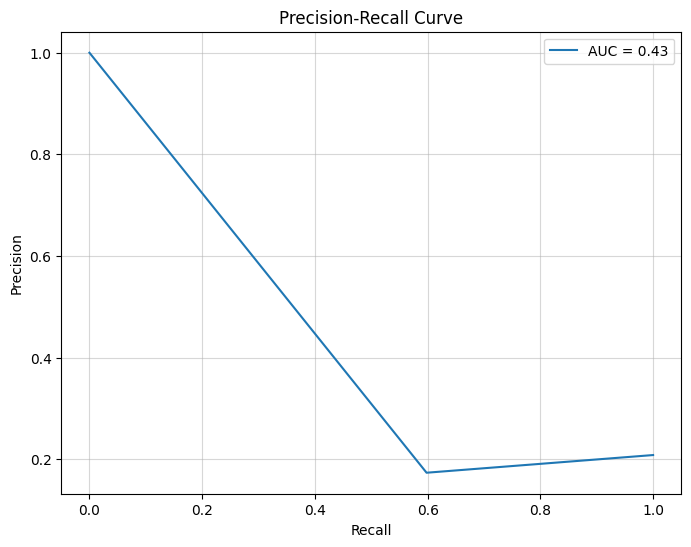

In [127]:
# Carregando pesos da melhor época
siamese_model.load_weights('best_model.h5')

# Avaliar o modelo na validação
y_pred_valid = (siamese_model.predict([valid_left_balanced, valid_right_balanced]) > 0.5)

# Avaliar o modelo no teste
y_pred_test = (siamese_model.predict([X_test_left, X_test_right]) > 0.5)

# Calcula a curva precision-recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_test)

# Calcula a AUC precision-recall
auc_pr = auc(recall, precision)

# Plote a curva precision-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(alpha=0.5)
plt.show()

In [128]:
# Gerar o relatório de classificação
print("Validação:")
print(classification_report(y_valid_balanced, y_pred_valid))
print("\n#########################################################\n")
print("Teste:")
print(classification_report(y_test, y_pred_test)) 

Validação:
              precision    recall  f1-score   support

           0       0.52      0.53      0.53       688
           1       0.52      0.51      0.52       688

    accuracy                           0.52      1376
   macro avg       0.52      0.52      0.52      1376
weighted avg       0.52      0.52      0.52      1376


#########################################################

Teste:
              precision    recall  f1-score   support

           0       0.70      0.25      0.37       794
           1       0.17      0.60      0.27       209

    accuracy                           0.32      1003
   macro avg       0.44      0.42      0.32      1003
weighted avg       0.59      0.32      0.35      1003



Validação:


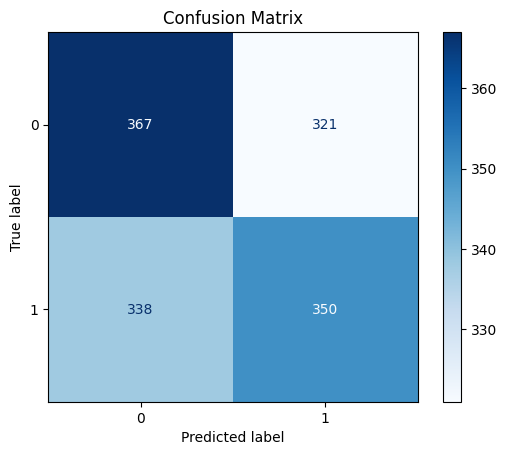


#########################################################

Teste:


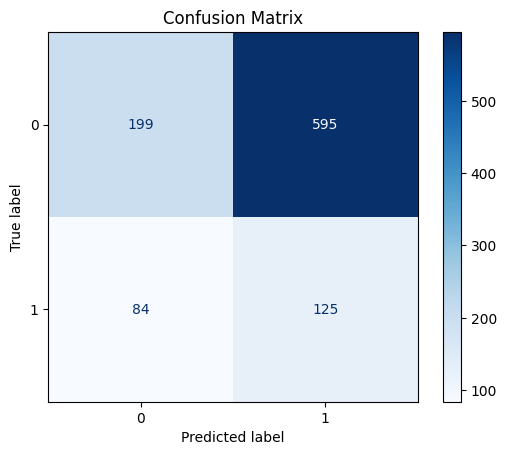

In [129]:
# Gerar a matriz de confusão
print("Validação:")
plot_confusion_matrix(y_valid_balanced, y_pred_valid)
print("\n#########################################################\n")
print("Teste:")
plot_confusion_matrix(y_test, y_pred_test)

In [130]:
def synchronize_classifications(classifications, grid_coordinates):
    """
    Sincroniza as classificações dos lados espelhados no grid (mesmo y, coordenadas da esquerda com seus espelhos à direita).

    Args:
        classifications (list): Lista de classificações ("TP", "TN", "FP", "FN").
        grid_coordinates (list): Lista de coordenadas [y1, y2, x1, x2] para os patches.

    Returns:
        list: Lista de classificações sincronizadas.
    """

    # Sincronizar classificações
    for i in range (len(grid_coordinates)//2):
        j = i + len(grid_coordinates)//2
        # Log temporário das classificações antes da sincronização
        print(f"Before Sync: Left[{i}]={classifications[i]}, Right[{j}]={classifications[j]}")

        # Se qualquer um dos lados for TP, FN, FP ou TN, ambos recebem a mesma classificação
        if classifications[i] == "TP" or classifications[j] == "TP":
            classifications[i] = "TP"
            classifications[j] = "TP"
        elif classifications[i] == "FP" or classifications[j] == "FP":
            classifications[i] = "FP"
            classifications[j] = "FP"
        elif classifications[i] == "TN" or classifications[j] == "TN":
            classifications[i] = "TN"
            classifications[j] = "TN"
        elif classifications[i] == "FN" or classifications[j] == "FN":
            classifications[i] = "FN"
            classifications[j] = "FN"

        # Log temporário das classificações após a sincronização
        print(f"After Sync: Left[{i}]={classifications[i]}, Right[{j}]={classifications[j]}")

    return classifications

def resize_patch(patch, target_size):
    """
    Redimensiona um patch para o tamanho desejado.
    
    Args:
        patch (numpy.ndarray): Patch a ser redimensionado.
        target_size (tuple): Tamanho alvo (altura, largura).

    Returns:
        numpy.ndarray: Patch redimensionado.
    """
    return cv2.resize(patch, target_size, interpolation=cv2.INTER_AREA)

def add_border(image, color, thickness=3):
    """
    Adiciona uma borda colorida ao redor de uma imagem, convertendo para RGB se necessário.
    
    Args:
        image (numpy.ndarray): Imagem original em escala de cinza.
        color (tuple): Cor da borda (RGB).
        thickness (int): Espessura da borda.

    Returns:
        numpy.ndarray: Imagem com a borda adicionada em formato RGB.
    """
    # Normalizar a imagem para o intervalo 0-255
    image_normalized = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Converter para RGB
    if len(image_normalized.shape) == 2:  # Se a imagem for escala de cinza
        image_rgb = cv2.cvtColor(image_normalized, cv2.COLOR_GRAY2RGB)
    else:
        image_rgb = image_normalized

    # Adicionar a borda
    bordered_image = cv2.copyMakeBorder(
        image_rgb, 
        thickness, thickness, thickness, thickness, 
        cv2.BORDER_CONSTANT, 
        value=color
    )
    
    return bordered_image


def build_image_with_grid(img, mask, grid_coordinates, classifications):
    """
    Reconstrói uma imagem e sua máscara usando as coordenadas de grid e pinta os patches com bordas coloridas.

    Args:
        img (numpy.ndarray): Imagem original.
        mask (numpy.ndarray): Máscara original.
        grid_coordinates (list): Lista de coordenadas [y1, y2, x1, x2] para os patches.
        classifications (list): Lista de classificações para os patches ("TP", "TN", "FP", "FN").

    Returns:
        tuple: Imagem reconstruída com bordas coloridas, máscara reconstruída com bordas coloridas.
    """
    # Tamanho da imagem reconstruída
    height, width = img.shape[:2]
    reconstructed_img = np.zeros((height+6, width+6, 3), dtype=np.uint8)
    reconstructed_mask = np.zeros((height+6, width+6, 3), dtype=np.uint8)

    # Mapeamento de cores para as classificações
    colors = {"TP": (0, 255, 0), "TN": (0, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}  # RGB

    # Iterar pelas coordenadas do grid e aplicar bordas coloridas
    for idx, (y1, y2, x1, x2) in enumerate(grid_coordinates):
        if idx >= len(grid_coordinates)//2:
            break
        
        (y3, y4, x3, x4) = grid_coordinates[idx+len(grid_coordinates)//2]
        patch_img = img[y1:y2+1, x1:x2+1]
        patch_mask = mask[y1:y2+1, x1:x2+1]
        patch_img_mirror = img[y3:y4+1, x3:x4+1]
        patch_mask_mirror = mask[y3:y4+1, x3:x4+1]
        
        # Total de pixels na subimagem
        total_pixels = patch_img.size
        # Número de pixels não-preto
        non_zero_pixels = np.count_nonzero(patch_img)
        # Proporção de pixels não-preto
        non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
        
        if non_black_ratio >= 0.08:
            # Adicionar borda colorida ao patch
            patch_img = add_border(patch_img, colors[classifications[idx]])
            patch_mask = add_border(patch_mask, colors[classifications[idx]])
            patch_img_mirror = add_border(patch_img_mirror, colors[classifications[idx+len(grid_coordinates)//2]])
            patch_mask_mirror = add_border(patch_mask_mirror, colors[classifications[idx+len(grid_coordinates)//2]])
        else:
            patch_img = resize_patch(patch_img, (46,46))
            patch_mask = resize_patch(patch_mask, (46,46))
            patch_img_mirror = resize_patch(patch_img_mirror, (46,46))
            patch_mask_mirror = resize_patch(patch_mask_mirror, (46,46))
            
            patch_img = cv2.cvtColor(cv2.normalize(patch_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U), cv2.COLOR_GRAY2RGB)
            patch_mask = cv2.cvtColor(cv2.normalize(patch_mask, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U), cv2.COLOR_GRAY2RGB)
            patch_img_mirror = cv2.cvtColor(cv2.normalize(patch_img_mirror, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U), cv2.COLOR_GRAY2RGB)
            patch_mask_mirror = cv2.cvtColor(cv2.normalize(patch_mask_mirror, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U), cv2.COLOR_GRAY2RGB)
        
        # Inserir os patches reconstruídos na imagem completa
        reconstructed_img[y1:y2+7, x1:x2+7] = patch_img
        reconstructed_mask[y1:y2+7, x1:x2+7] = patch_mask
        reconstructed_img[y3:y4+7, x3:x4+7] = patch_img_mirror
        reconstructed_mask[y3:y4+7, x3:x4+7] = patch_mask_mirror
        
    return reconstructed_img, reconstructed_mask

In [108]:

# Função para carregar a imagem e a máscara inteiras
def load_full_image_and_mask(image_path, mask_path):
    images = {}
    masks = {}
    patient_ids = []
    for patient_id, mask_id in tqdm(zip(os.listdir(image_path), os.listdir(mask_path)), desc="Carregamento de arquivos NIfTI..."):
        patient_path = os.path.join(image_path, patient_id)
        mask_patient_path = os.path.join(mask_path, mask_id)
        patient_ids.append(patient_id)
        images[patient_id] = []
        masks[patient_id] = []
        for patch_id, mask_patch_id in zip(os.listdir(patient_path), os.listdir(mask_patient_path)):
            img = nib.load(os.path.join(patient_path, patch_id)).get_fdata()
            mask = nib.load(os.path.join(mask_patient_path, mask_patch_id)).get_fdata()
            images[patient_id].append(img)
            masks[patient_id].append(mask)

    return images, masks

def plot_patient_slices_with_grid(pdf_filename, patients, images, masks, labels_true, labels_pred):
    """
    Gera um PDF com imagens de pacientes, suas máscaras e grids reconstruídos, destacando áreas com displasia e seus espelhos.

    Args:
        pdf_filename (str): Nome do arquivo PDF.
        patients (list): Lista de IDs dos pacientes.
        images (dict): Dicionário com imagens completas dos pacientes.
        masks (dict): Dicionário com máscaras completas dos pacientes.
        grids (dict): Dicionário com grids (coordenadas) para os pacientes.
        labels_true (list): Labels verdadeiros das fatias.
        labels_pred (list): Labels preditos das fatias.
    """
    
    start_time = time()
    with PdfPages(pdf_filename) as pdf:
        for patient in patients:
            patient_start_time = time()
            print(f"Paciente: {patient}\n\n")

            cont = 0
            for img, mask in zip(images[patient], masks[patient]):
                classifications = []

                for idx, pred in enumerate(labels_pred[cont:cont + len(coordinates_grid[patient_id])]):
                    true_label = labels_true[cont + idx]
                    if pred == 1:
                        if true_label == 1:
                            classifications.append("TP")  # Verdadeiro positivo
                        else:
                            classifications.append("FP")  # Falso positivo
                    elif pred == 0:
                        if true_label == 1:
                            classifications.append("FN")  # Falso negativo
                        else:
                            classifications.append("TN")  # Verdadeiro negativo

                    # Validar tamanhos
                    if len(coordinates_grid[patient_id]) != len(classifications):
                        print(f"Mismatch in sizes: {len(coordinates_grid[patient_id])} grid coords, {len(classifications)} classifications.")
                        continue
                    
                    # Sincronizar classificações entre os lados opostos
                    classifications = synchronize_classifications(classifications, coordinates_grid[patient_id])

                    # Reconstruir imagem e máscara usando o grid
                    reconstructed_img, reconstructed_mask = build_image_with_grid(
                        img, mask, coordinates_grid[patient_id], classifications
                    )

                    # Configurar a figura
                    plt.figure(figsize=(8, 8))

                    # Mostrar a imagem original
                    plt.subplot(1, 2, 1)
                    plt.imshow(reconstructed_img, cmap='gray')
                    plt.title(f"{patient} - Slice")

                    # Criar lista para coordenadas destacadas
                    highlighted_grids = []

                    # Desenhar os grids na imagem original
                    for idx, (y1, y2, x1, x2) in enumerate(coordinates_grid[patient_id]):
                        if y1 == -1 and y2 == -1 and x1 == -1 and x2 == -1:
                            continue

                        # Verifica a classificação do grid atual
                        classification = classifications[idx]

                        # Define a cor e a espessura da linha com base na classificação
                        if classification == "TP" or classification == "TN":
                            color = 'green'  # Verdadeiros positivos ou negativos
                            linewidth = 3
                        elif classification == "FP":
                            color = 'red'  # Falsos positivos
                            linewidth = 3
                        elif classification == "FN":
                            color = 'yellow'  # Falsos negativos
                            linewidth = 3
                        else:
                            color = 'gray'  # Padrão (não deve ocorrer)
                            linewidth = 1

                        # Desenha o grid na imagem original
                        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color=color, linewidth=linewidth)

                        # Salva as coordenadas dos grids destacados para desenhar o espelho
                        if classification == "TP" or classification == "FP" or classification == "FN":
                            highlighted_grids.append((y1, y2, x1, x2))

                    # Desenhar grids espelhados
                    for (y1, y2, x1, x2) in highlighted_grids:
                        x1_mirror = img.shape[1] - x2
                        x2_mirror = img.shape[1] - x1

                        # Verifica a classificação do grid original para aplicar a mesma cor ao espelho
                        classification = classifications[coordinates_grid[patient_id].index((y1, y2, x1, x2))]

                        if classification == "TP" or classification == "TN":
                            color = 'green'  # Verdadeiros positivos ou negativos
                            linewidth = 3
                        elif classification == "FP":
                            color = 'red'  # Falsos positivos
                            linewidth = 3
                        elif classification == "FN":
                            color = 'yellow'  # Falsos negativos
                            linewidth = 3
                        else:
                            color = 'gray'  # Padrão (não deve ocorrer)
                            linewidth = 1

                        # Desenha o grid espelhado
                        plt.plot([x1_mirror, x2_mirror, x2_mirror, x1_mirror, x1_mirror], 
                                [y1, y1, y2, y2, y1], 
                                color=color, linewidth=linewidth)

                    # Mostrar a máscara correspondente
                    plt.subplot(1, 2, 2)
                    plt.imshow(reconstructed_mask, cmap='gray')
                    plt.title(f"{patient} - Slice_Mask")

                    # Desenhar os grids na máscara
                    for idx, (y1, y2, x1, x2) in enumerate(coordinates_grid[patient_id]):
                        if y1 == -1 and y2 == -1 and x1 == -1 and x2 == -1:
                            continue

                        # Verifica a classificação do grid atual
                        classification = classifications[idx]

                        # Define a cor e a espessura da linha com base na classificação
                        if classification == "TP" or classification == "TN":
                            color = 'green'  # Verdadeiros positivos ou negativos
                            linewidth = 3
                        elif classification == "FP":
                            color = 'red'  # Falsos positivos
                            linewidth = 3
                        elif classification == "FN":
                            color = 'yellow'  # Falsos negativos
                            linewidth = 3
                        else:
                            color = 'gray'  # Padrão (não deve ocorrer)
                            linewidth = 1

                        # Desenha o grid na máscara
                        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color=color, linewidth=linewidth)

                    # Desenhar grids espelhados na máscara
                    for (y1, y2, x1, x2) in highlighted_grids:
                        x1_mirror = img.shape[1] - x2
                        x2_mirror = img.shape[1] - x1

                        # Verifica a classificação do grid original para aplicar a mesma cor ao espelho
                        classification = classifications[coordinates_grid[patient_id].index((y1, y2, x1, x2))]

                        if classification == "TP" or classification == "TN":
                            color = 'green'  # Verdadeiros positivos ou negativos
                            linewidth = 3
                        elif classification == "FP":
                            color = 'red'  # Falsos positivos
                            linewidth = 3
                        elif classification == "FN":
                            color = 'yellow'  # Falsos negativos
                            linewidth = 3
                        else:
                            color = 'gray'  # Padrão (não deve ocorrer)
                            linewidth = 1

                        # Desenha o grid espelhado na máscara
                        plt.plot([x1_mirror, x2_mirror, x2_mirror, x1_mirror, x1_mirror], 
                                [y1, y1, y2, y2, y1], 
                                color=color, linewidth=linewidth)

                    # Adicionar ao PDF
                    pdf.savefig()
                    plt.close()

                    cont += len(coordinates_grid[patient_id])

            # Tempo gasto por paciente
            patient_end_time = time()
            patient_duration = patient_end_time - patient_start_time
            print(f"Tempo para o paciente {patient}: {patient_duration:.2f} segundos\n")

    end_time = time()
    total_duration = end_time - start_time
    print(f"Tempo total de execução: {total_duration:.2f} segundos")
    print(f"As imagens foram salvas no arquivo PDF {pdf_filename} com sucesso.")

# Caminhos das imagens e máscaras
image_path = "Fatias"
mask_path = "Mask_Fatias"

# Carregar e plotar as imagens
images, masks = load_full_image_and_mask(image_path, mask_path)

# Processar Teste
plot_patient_slices_with_grid(
    pdf_filename="Pdf_SNN/Pacientes_Test_Reconstruidos_Grid.pdf",
    patients=test_patients,
    images=images,
    masks=masks,
    labels_true=y_test,
    labels_pred=y_pred_test
)

Carregamento de arquivos NIfTI...: 21it [01:49,  5.19s/it]


KeyboardInterrupt: 